# Robustness of Crayfish Nervous System to Environmental pH
## Step 1: Format Data

In [1]:
import neo, os
import numpy as np
from mne import create_info
from mne.io import RawArray

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
include = '171212'

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main body.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Locate files.
files = [f for f in os.listdir('raw') if f.endswith('abf')]
files = [f for f in files if include in f]

for f in files:

    ## Load recordings.
    recordings, = neo.AxonIO(filename='raw/%s' %f).read_block().segments
    signal, = recordings.analogsignals

    ## Concatenate raw recordings.
    data = np.hstack([np.asarray(signal, dtype=np.float64)  * 1e-6]).T
    
    ## Create info object.
    sfreq = float(signal.sampling_rate)
    ch_names = ['nerve']
    ch_types = 'eeg'

    info = create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

    ## Create Raw object.
    raw = RawArray(data, info, verbose=False)
        
    ## Save Raw object.  
    raw.save('raw/%s' %f.replace('.abf','_raw.fif'), overwrite=True, verbose=False)
    
print('Done.')

Done.


## Step 2: Spike Detection

In [2]:
import os
import numpy as np
from mne import Epochs
from mne.io import Raw
from spike_sorting import find_threshold, peak_finder

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Filter parameters.
l_freq = 300
h_freq = 3000

## Spike detection parameters.
k = 5

## Epoching parameters.
tmin = -0.002
tmax = 0.001
reject_tmax = -0.001

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

files = [f for f in os.listdir('raw') if f.endswith('fif')]
for f in files:
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Load and prepare data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Load raw.
    raw = Raw('raw/%s' %f, preload=True, verbose=False)

    ## Filter data.
    raw = raw.filter(l_freq, h_freq, picks=[0], method='fir', phase='zero', 
                     fir_design='firwin', verbose=False)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Spike detection.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Extract data.
    data = raw.get_data().squeeze()

    ## Set threshold.
    threshold = find_threshold(data, k)

    ## Detect spikes.
    peak_loc, peak_mag =  peak_finder(data, threshold)
    if not np.any(peak_loc): continue
    
    ## Epoching.
    events = np.vstack([peak_loc, np.zeros_like(peak_loc), np.ones_like(peak_loc)]).T
    epochs = Epochs(raw, events, tmin=tmin, tmax=tmax, picks=[0], baseline=(tmin, reject_tmax),
                    reject=dict(eeg=threshold), reject_tmax=reject_tmax, preload=True, verbose=False)
    
    ## Drop bad epochs. Crop.
    epochs.drop_bad()
    epochs = epochs.crop(reject_tmax, tmax)

    ## Extract data.
    spikes = epochs.get_data().squeeze()
    spikes *= 1e6 # convert to uV
    if np.ndim(spikes) == 1: spikes = spikes.reshape(1,-1)
    
    ## Save.
    np.savez_compressed('spikes/%s' %f.replace('raw.fif','spikes.npz'), spikes=spikes, times=epochs.times,
                        peak_loc=peak_loc, peak_mag=peak_mag)
        
print('Done.')

Done.


## Step 3:  Spike Rejection

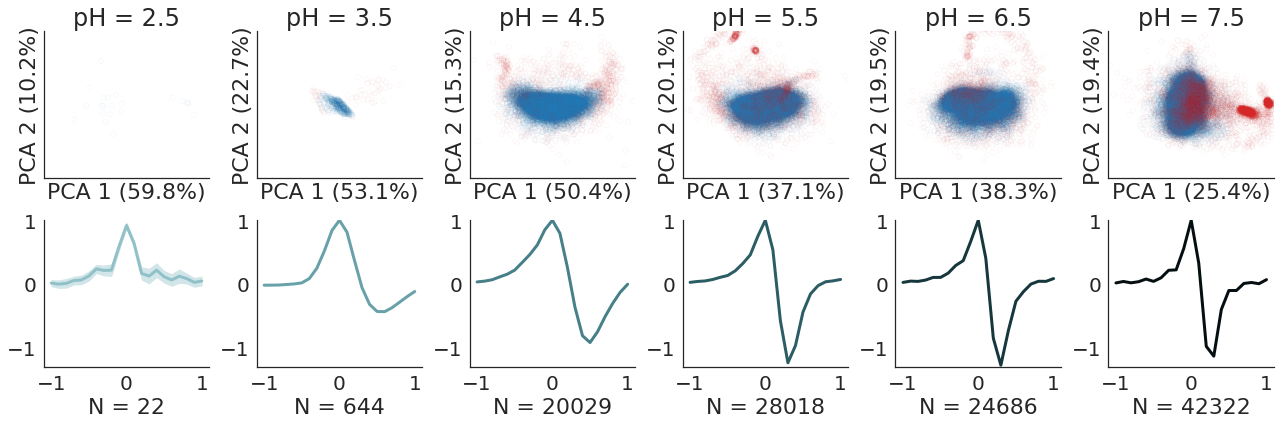

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import cauchy, norm
sns.set_style('white')
sns.set_context('notebook', font_scale=2)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
pH_levels = np.arange(25,80,10)

## PCA parameters.
n_components = 2

## Rejection parameters.
alpha = 0.05

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(2, pH_levels.size, figsize=(18,6))
colors = sns.cubehelix_palette(n_colors=6, start=2.5, rot=0, dark=0.05, light=.7)

## Initialize Scikit-Learn objects.
pca = PCA(n_components=n_components, random_state=0)
log_likelihood = lambda arr: np.log( norm(arr.mean(), arr.std()).pdf(arr) )

for i, pH in enumerate(pH_levels):

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Load and prepare data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Locate files.
    files = sorted([f for f in os.listdir('spikes') if str(pH) in f])
    
    ## Iteratively load files.
    spikes, recordings = [], []
    for f in files:
        npz = np.load('spikes/%s' %f)
        spikes.append(npz['spikes'])
        recordings.append( np.ones(spikes[-1].shape[0]) * int(f.split('_')[-2]) )
    
    ## Concatenate files.
    spikes = np.concatenate(spikes,axis=0)
    recordings = np.concatenate(recordings)
    times = npz['times'] * 1e3
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Spike rejection.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Normalize spikes by maximum value per spike.
    normed = (spikes.T / spikes.max(axis=-1)).T
    
    ## Dimensionality reduction with PCA.
    pca_fit = pca.fit_transform(normed)
    evr = pca.explained_variance_ratio_
    
    ## Compute log-likelihood of spikes relative to template (average).
    log_lik = np.apply_along_axis(log_likelihood, 0, normed)
    log_lik = np.mean(log_lik, axis=-1)
    
    ## Fit to cauchy distribution.
    mu, sd = cauchy.fit(log_lik)
    threshold = cauchy(mu, sd).ppf(alpha)
    ix = log_lik > threshold
    
    ## Save cleaned data.
    np.savez_compressed('templates/spikes_%s.npz' %pH, spikes=spikes[ix], 
                        recordings=recordings[ix], times=times)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Plotting..
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Plot PCA.
    axes[0,i].scatter(*pca_fit[ix].T, s=25, color='none', edgecolor='#1f77b4', alpha=0.1)
    axes[0,i].scatter(*pca_fit[~ix].T, s=25, color='none', edgecolor='#d62728', alpha=0.1)
    axes[0,i].set(xlim=(-3,3), xticks=[], xlabel='PCA 1 (%0.1f%%)' %(evr[0]*100), 
           ylim=(-3,3), yticks=[], ylabel='PCA 2 (%0.1f%%)' %(evr[1]*100),
           title='pH = %0.1f' %(pH/10))
    
    ## Plot template.
    mu = normed[ix].mean(axis=0)
    se = normed[ix].std(axis=0) / np.sqrt(normed[ix].shape[0])
    axes[1,i].plot(times, mu, lw=3, color=colors[i])
    axes[1,i].fill_between(times, mu - se, mu + se, color=colors[i], alpha=0.4)
    axes[1,i].set(ylim=(-1.3,1), xlabel='N = %s' %normed[ix].shape[0])
    
sns.despine()
plt.tight_layout()

In [ ]:
from scipy.optimize import curve_fit

def logistic(arr): 
    return 1 / (1 + np.exp(-arr))

def sigmoid(x, A, T, D): 
    return A * logistic( (x - T) / D )

def inverse_logit(times, T1, D1, A2, T2, D2, T3, D3):

    ## 
    A1 = 1
    rising_phase = sigmoid(times[times <= 0], A1, T1, D1)

    ## Estimate refractory period.
    A3 = np.abs(A2) - np.abs(A1)
    refractory_phase = 1 + sigmoid(times[times > 0], A2, T2, D2) +\
                       sigmoid(times[times > 0], A3, T3, D3)
        
    return np.concatenate([rising_phase,refractory_phase])

## Make template.
template = normed[clusters==1].mean(axis=0)
times = np.linspace(-1,1,template.size)

## Fit model.
p, _ = curve_fit(inverse_logit, times, template, p0=[-0.1, 0.05, -1.2, 0.1, 0.05, 0.4, 0.05])
# p, _ = curve_fit(inverse_logit, times, template, p0=[-0.2,0.05,-0.7,0.1,0.05,0.7,0.05])

## Plot.
plt.plot(times, template)
plt.plot(times, inverse_logit(times, *p))